In [1]:
import pygplates
import sys
import numpy as np
sys.path.append('../../GPlatesClassStruggle')
sys.path.append('../../atom_utils')
sys.path.append('../../passive_margins/')
from raster_reconstruction_classes import *
import matplotlib.pyplot as plt
#from reconstruct_atom_rasters import *
#import points_spatial_tree
#import points_in_polygons
#import paleogeography as pg
#import tectonic_subsidence as ts 

%matplotlib inline
%load_ext autoreload
%autoreload 2

from grdbacktrack import *


agegrid = GplatesRaster('../data/agegrid_final_mask_0.nc')

topography = GplatesRaster('../data/ETOPO1_0.1.grd')

anomalous_ocean = GplatesRaster('../data/Wessel_lip_seamount_mask.nc')

sediment_thickness = GplatesRaster('../data/sedthick_world_v3_5min_epsg4326_cf.nc')


rotation_filename = '/Users/Simon/GIT/agegrid-dev/input_files/Rotations/Matthews_etal_GPC_2016_410-0Ma_GK07.rot'

# Note: must be static polygons that have the conjugate plateid assigned
static_polygon_filename = '/Users/Simon/GIT/passive_margins/input_data/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons_2015_v1.shp'

rotation_model = pygplates.RotationModel(rotation_filename)
static_polygon_features = pygplates.FeatureCollection(static_polygon_filename)


In [2]:
points, point_plate_pairs, point_ages = sample_seafloor_age_model(static_polygon_features, agegrid, 64)


working on plate pair [201, 701]
working on plate pair [201, 714]
working on plate pair [101, 714]
working on plate pair [101, 304]
working on plate pair [101, 317]
working on plate pair [101, 301]
working on plate pair [102, 301]
working on plate pair [102, 907]
working on plate pair [301, 977]
working on plate pair [102, 101]


/Users/Simon/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


AttributeError: 'AxesSubplot' object has no attribute 'xlabel'

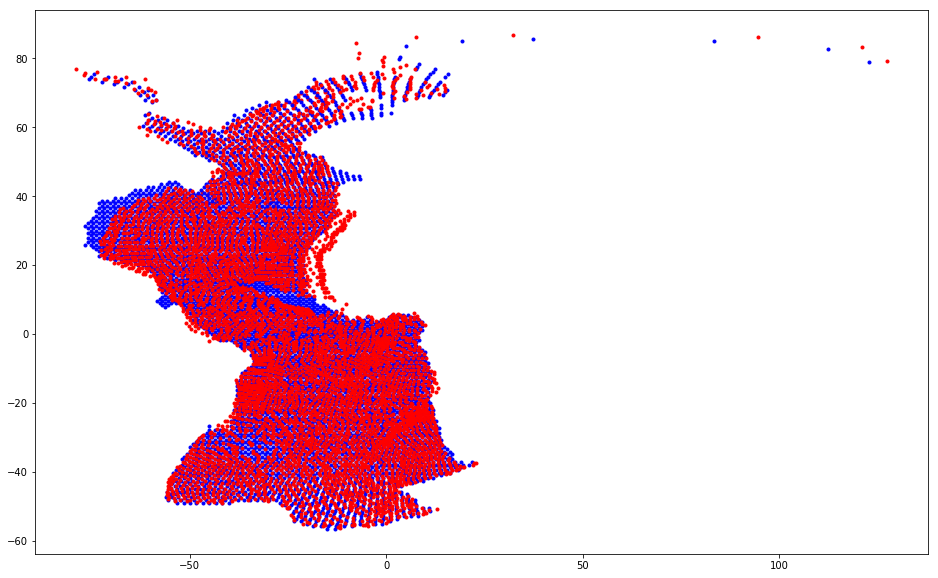

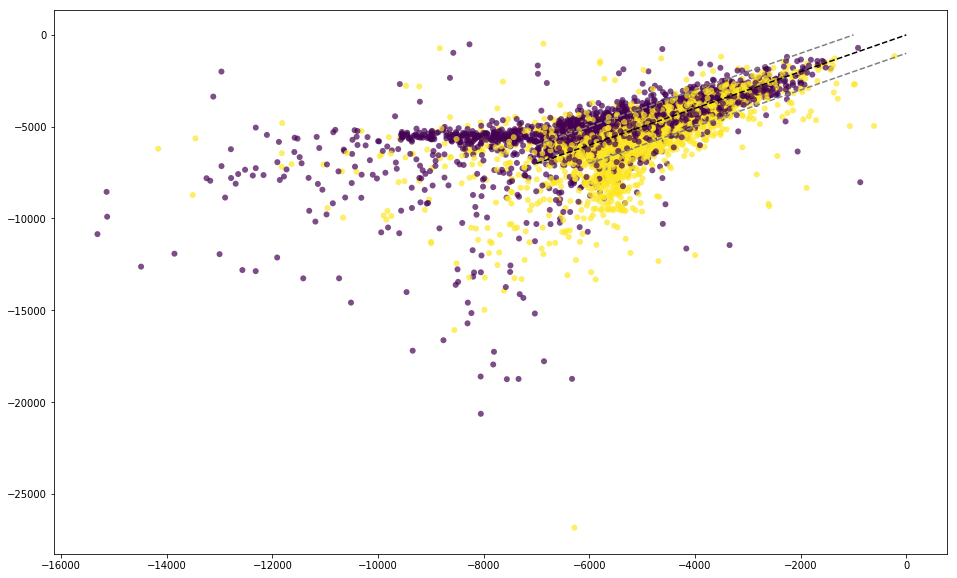

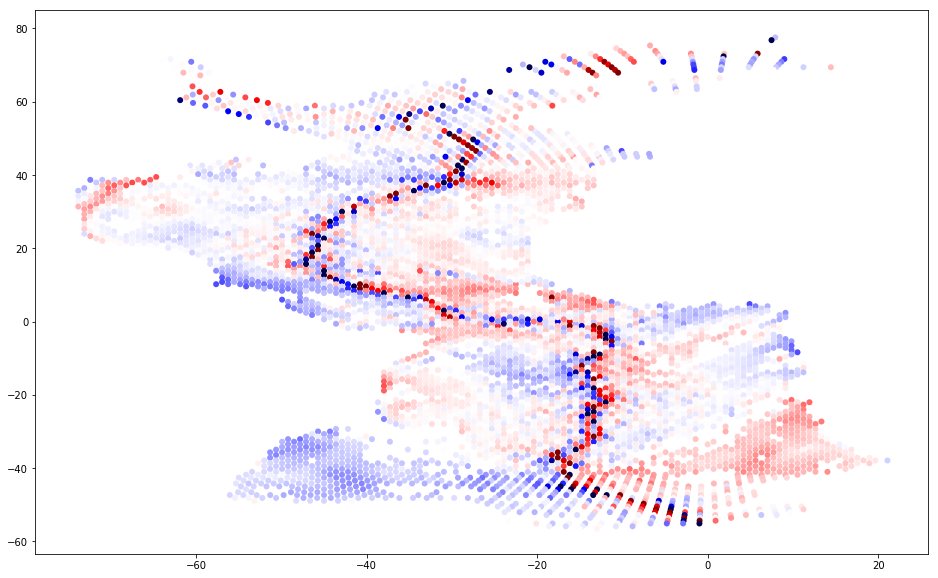

In [6]:
# the returned object is  list of lists, where each list entry contains
# a list for one point, with 6 values
# longitude, latitude, conjugate_longitude, conjugate_latitude, plate_id, seafloor_age


list_of_plate_pairs = [[201,701],
                       [201,714],
                       [101,714],
                       [101,304],
                       [101,317],
                       [101,301],
                       [102,301],
                       [102,907],
                       [301,977],
                       [102,101]]


fig1 = plt.figure(figsize=(16,10))
ax1 = fig1.add_subplot(1, 1, 1)
fig2 = plt.figure(figsize=(16,10))
ax2 = fig2.add_subplot(1, 1, 1)
fig3 = plt.figure(figsize=(16,10))
ax3 = fig3.add_subplot(1, 1, 1)

for target_plate_pair in list_of_plate_pairs:
    
    print 'working on plate pair %s' % target_plate_pair

    points_and_conjugate_points = return_conjugate_points(points, 
                                                          point_ages, 
                                                          point_plate_pairs,
                                                          target_plate_pair,
                                                          rotation_model)


    point_longitudes = np.array(zip(*points_and_conjugate_points)[0])
    point_latitudes = np.array(zip(*points_and_conjugate_points)[1])
    conjugate_longitudes = np.array(zip(*points_and_conjugate_points)[2])
    conjugate_latitudes = np.array(zip(*points_and_conjugate_points)[3])
    point_plate_ids = np.array(zip(*points_and_conjugate_points)[4])
    point_seafloor_ages = np.array(zip(*points_and_conjugate_points)[5])


    # this plot checks to see that the points (blue) and their conjugates (rec)
    # all plot on top of one another, which they should do for us to be sampling grids
    # correctly

    point_depth = get_unloaded_bsmt_depth(point_longitudes,point_latitudes,topography,sediment_thickness)    
    conj_point_depth = get_unloaded_bsmt_depth(conjugate_longitudes,conjugate_latitudes,topography,sediment_thickness)

    point_depth_mask = anomalous_ocean.sample_using_gmt(point_longitudes,point_latitudes)    
    conj_point_depth_mask = anomalous_ocean.sample_using_gmt(conjugate_longitudes,conjugate_latitudes)
    mask = np.any(np.vstack((point_depth_mask,conj_point_depth_mask)),axis=0)


    a2d = pg.age2depth(point_seafloor_ages)

    asymmetric_residual_basement_depth = point_depth - a2d
    symmetric_residual_basement_depth = np.mean(np.vstack((point_depth,conj_point_depth)),axis=0) - a2d


    # the term anomalous subsidence is used to describe the different between the expected depth based
    # on age depth relationship and the the depth we need will impose to ensure the ocean basin
    # always looks symmetric
    # We 'know' the anomalous subsidence at two times:
    # 1. present-day
    # 2. The birth time of the point and its conjugate
    # Values in between are derived by linear interpolation

    # Example:
    # suppose point A lies on 50 Ma crust, and has a residual topography at present-day of +500m
    # its conjugate (point B) has a residual topography of +100m
    # --> at 50 Ma, we assume the MOR depth was 300 m above 'normal' (which is 2600m?)
    # --> assume that the 'anomalous' depth for point A changes linearly from 500m to 300m between 0Ma and 50Ma
    # --> 'anomalous' depth for point A changes linearly from 100m to 300m between 0Ma and 50Ma

    # --> Rate of anomalous subsidence - positive values mean the residual depth has been increasing through time (greater now than in the past)
    anomalous_subsidence_rate = (asymmetric_residual_basement_depth - symmetric_residual_basement_depth) / np.array(zip(*points_and_conjugate_points)[5])

    ax1.plot(point_longitudes,point_latitudes,'b.')
    ax1.plot(conjugate_longitudes,conjugate_latitudes,'r.')
    
    ax2.scatter(point_depth[~mask],conj_point_depth[~mask],c=point_plate_ids[~mask],edgecolors='',alpha=0.7)

    ax3.scatter(point_longitudes[~mask],
                 point_latitudes[~mask],
                 c=anomalous_subsidence_rate[~mask],
                 edgecolors='',vmin=-100,vmax=100,
                 cmap=plt.cm.seismic)

fig1.show()

ax2.plot([-7000,0],[-7000,0],'k--')
ax2.plot([-7000,-1000],[-6000,0],'--',color='gray')
ax2.plot([-6000,0],[-7000,-1000],'--',color='gray')
ax2.xlabel('Depth on Plate')
ax2.ylabel('Depth on Conjugate Plate')
ax2.colorbar()
ax2.show()

ax3.colorbar()
fig3.show()

'''   
########################################################
recon_time = 50.

# expected depth at present
a2d_present = pg.age2depth(point_seafloor_ages)

# expected depth at reconstruction time
a2d_recon = pg.age2depth(point_seafloor_ages - recon_time)

# expected subsidence between present and reconstruction time
expected_subsidence = a2d_recon - a2d_present

anomalous_subsidence_at_recon_time = anomalous_subsidence_rate * recon_time

total_subsidence = expected_subsidence - anomalous_subsidence_at_recon_time

backtracked_depth = point_depth + total_subsidence
''' 




